# Exercises

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

Text(0, 0.5, 'y')

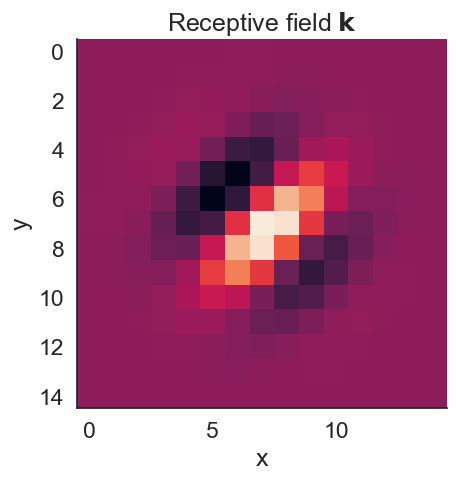

In [19]:
size = vf_size # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # pahse of the gabor pathc


xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))

# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))

# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.amax(np.abs(K))

plt.imshow(K)
plt.title(r'Receptive field $\bf{k}$')
plt.xlabel('x')
plt.ylabel('y')

In [20]:
noise_variance=1
offset = 2.

In [21]:
# genration of the stimulus 

duration = [5,10,20,40,80,160,320,640]
dt = .1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / float(dt))


S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

In [22]:
def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

In [28]:
import numpy as np

durations = [5, 10, 20, 40, 80, 160, 320, 640]
spike_rate = 5  # average firing rate 

# flatten the matrices into 1d array for convenience
K_flat = K.ravel()
K_flat = np.hstack((K_flat, offset))

S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2])
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

# Iterate over each duration
for duration in durations:
    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    # lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
    # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
    # across all bins gives the expected number of spikes for the whole draw.
    expected_rate = np.sum(lamda * dt) / duration
    lamda *= (spike_rate / expected_rate)

    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times, bins=np.arange(n_bins + 1) * dt)[0]

    print(f"Duration: {duration} seconds")
    print(f"Average spike rate: {len(spike_times) / duration:.2f} spikes per second\n")

Duration: 5 seconds
Average spike rate: 3.00 spikes per second

Duration: 10 seconds
Average spike rate: 3.80 spikes per second

Duration: 20 seconds
Average spike rate: 3.95 spikes per second

Duration: 40 seconds
Average spike rate: 4.22 spikes per second

Duration: 80 seconds
Average spike rate: 4.65 spikes per second

Duration: 160 seconds
Average spike rate: 4.65 spikes per second

Duration: 320 seconds
Average spike rate: 4.88 spikes per second

Duration: 640 seconds
Average spike rate: 4.96 spikes per second



In [27]:
import numpy as np

durations = [5, 10, 20, 40, 80, 160, 320, 640]
spike_rate = 5  # average firing rate 

# flatten the matrices into 1d array for convenience
K_flat = K.ravel()
K_flat = np.hstack((K_flat, offset))

S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2])
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

# Iterate over each duration
for duration in durations:
    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    # lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
    # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
    # across all bins gives the expected number of spikes for the whole draw.
    expected_rate = np.sum(lamda * dt) / duration
    lamda *= (spike_rate / expected_rate)

    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times, bins=np.arange(n_bins + 1) * dt)[0]

    print(f"Duration: {duration} seconds")
    print(f"Average spike rate: {len(spike_times) / duration:.2f} spikes per second\n")

Duration: 5 seconds
Average spike rate: 3.00 spikes per second

Duration: 10 seconds
Average spike rate: 3.50 spikes per second

Duration: 20 seconds
Average spike rate: 4.10 spikes per second

Duration: 40 seconds
Average spike rate: 4.20 spikes per second

Duration: 80 seconds
Average spike rate: 4.41 spikes per second

Duration: 160 seconds
Average spike rate: 4.73 spikes per second

Duration: 320 seconds
Average spike rate: 4.91 spikes per second

Duration: 640 seconds
Average spike rate: 4.87 spikes per second



Duration: 5 seconds
Average Pearson correlation = 0.414



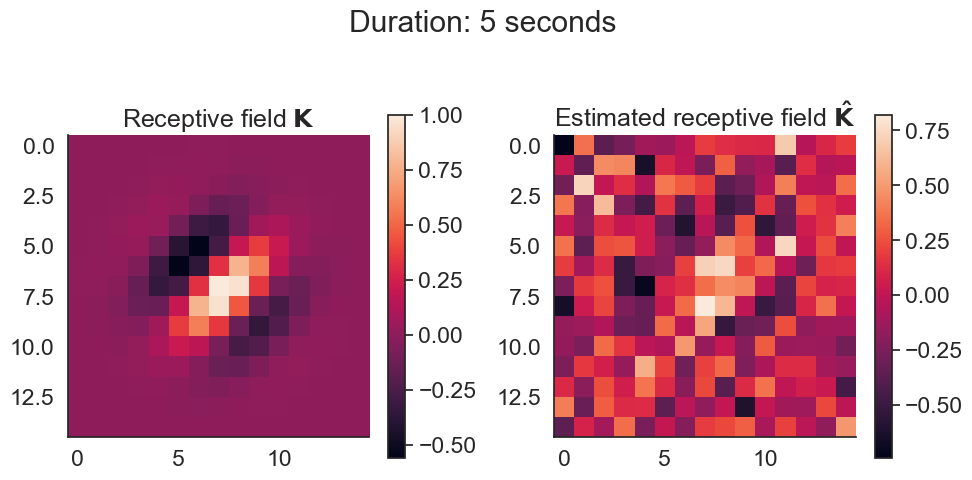

Duration: 10 seconds
Average Pearson correlation = 0.520



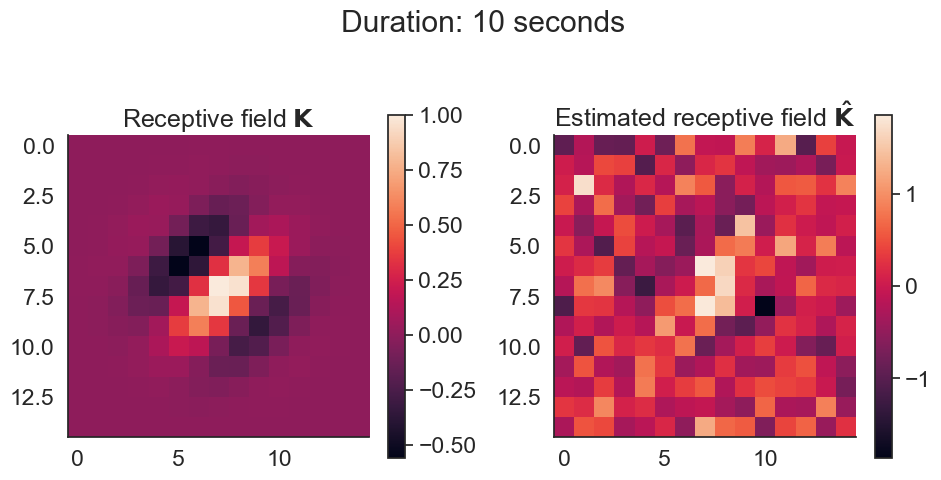

Duration: 20 seconds
Average Pearson correlation = 0.574



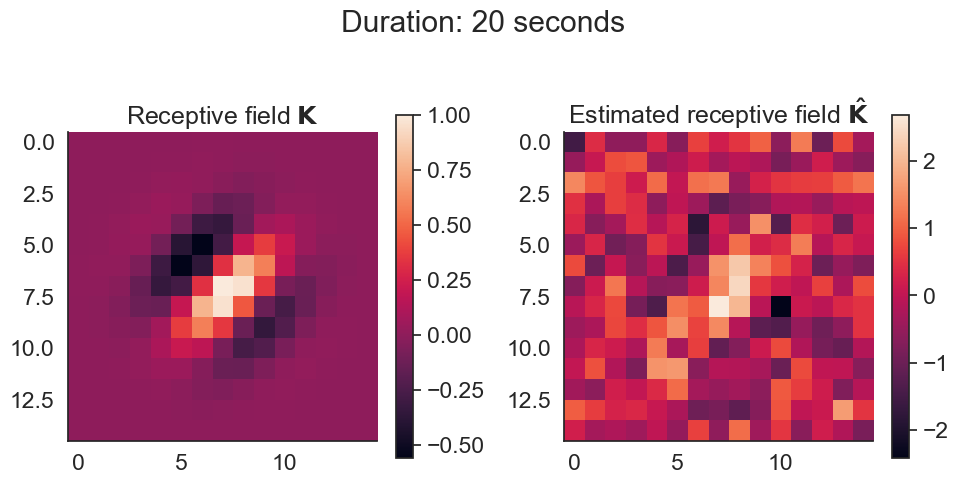

Duration: 40 seconds
Average Pearson correlation = 0.677



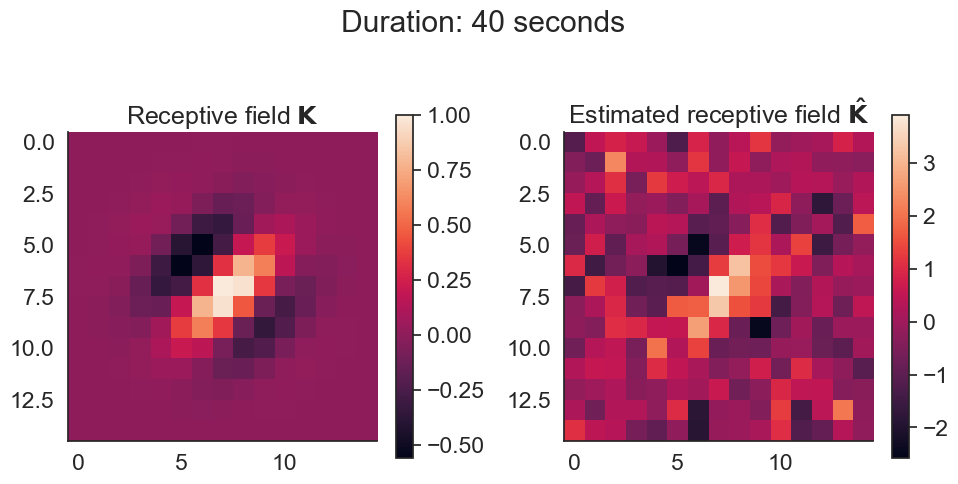

Duration: 80 seconds
Average Pearson correlation = 0.749



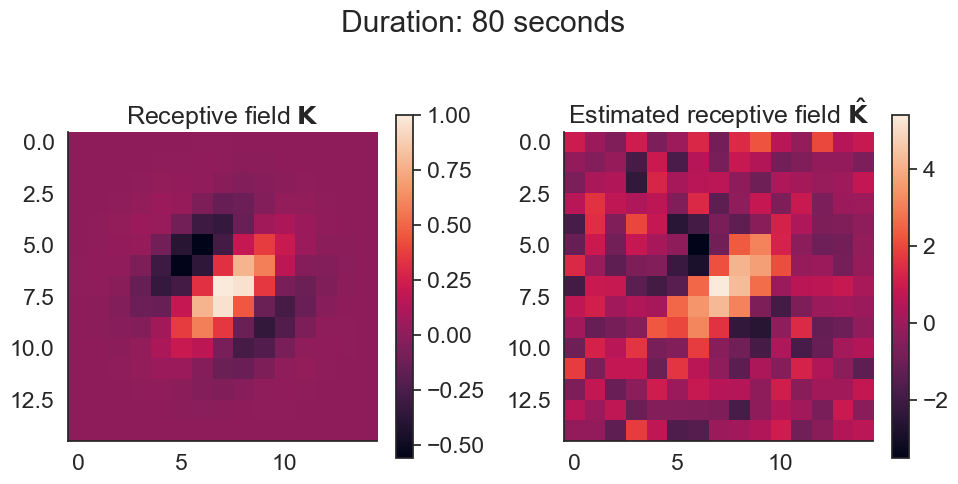

Duration: 160 seconds
Average Pearson correlation = 0.754



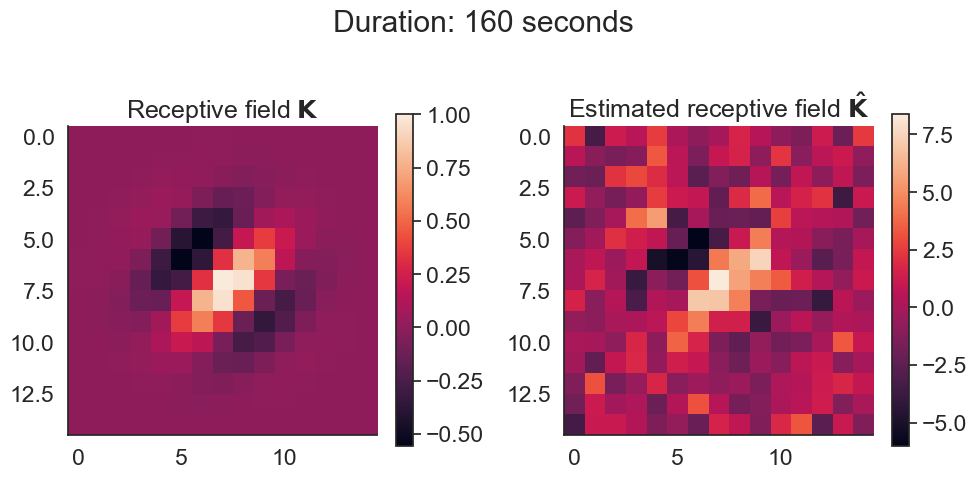

Duration: 320 seconds
Average Pearson correlation = 0.782



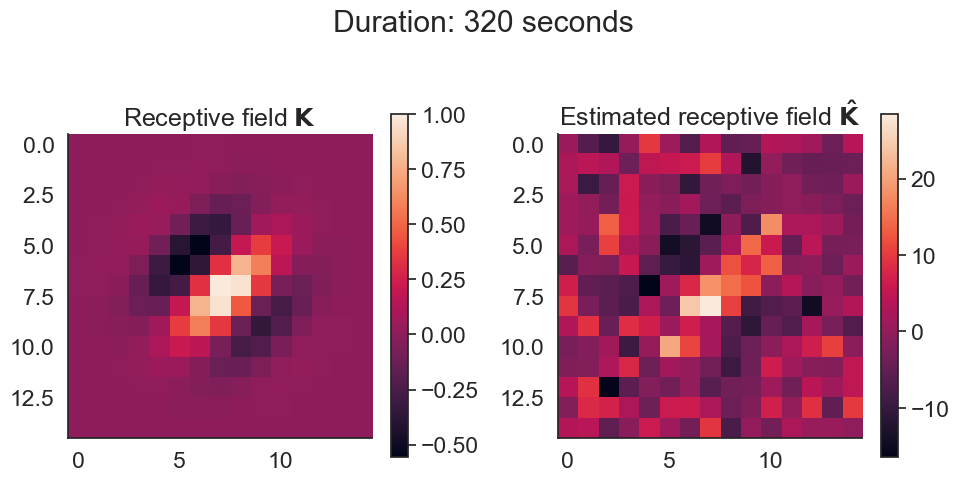

Duration: 640 seconds
Average Pearson correlation = 0.961



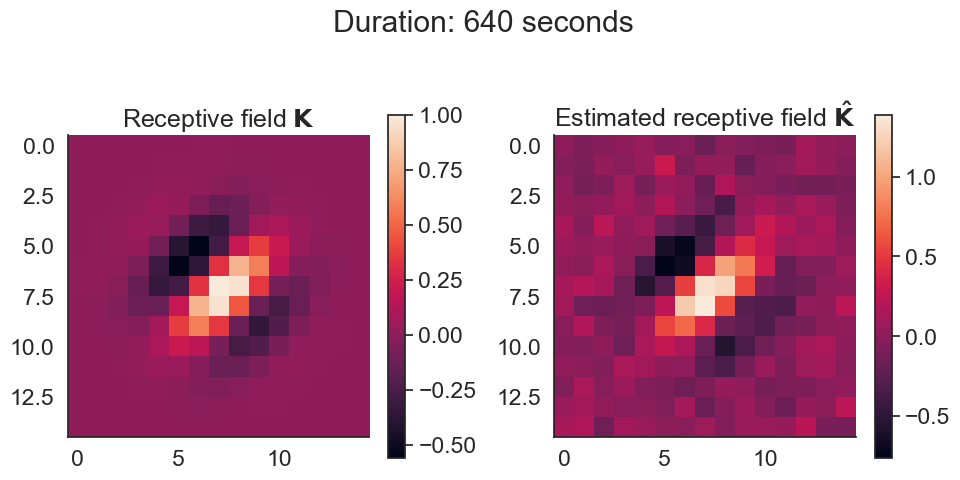

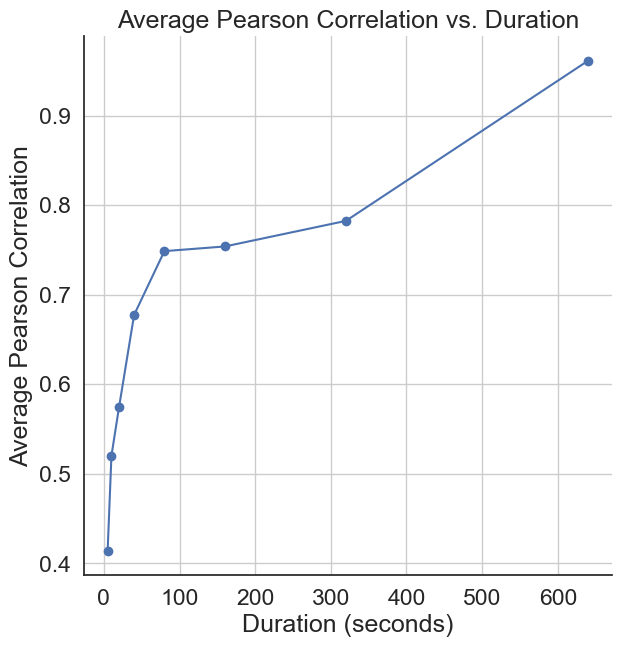

In [38]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define functions for minimization
def cost(k, spike_counts, S, dt):
    # Negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)

def grad(k, spike_counts, S, dt):
    # Expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt * lamda)

# Assuming the required functions and variables are already defined:
# K, S, n_bins, dt, offset, generate_inhomogeneous_poisson_spikes

durations = [5, 10, 20, 40, 80, 160, 320, 640]
spike_rate = 5  # average firing rate 
num_realizations = 10  # number of realizations for averaging

# Flatten the matrices into 1d array for convenience
K_flat = K.ravel()
K_flat = np.hstack((K_flat, offset))

S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2])
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

average_correlations = []

for duration in durations:
    correlations = []
    for _ in range(num_realizations):
        # 1. Linear stage
        ks = np.dot(K_flat, S_flat.T)

        # 2. Nonlinear stage (for a linear model: f -> identity function)
        lamda = np.exp(ks)

        # Lambda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
        # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
        # across all bins gives the expected number of spikes for the whole draw.
        expected_rate = np.sum(lamda * dt) / duration
        lamda *= (spike_rate / expected_rate)

        # Generate spike times using an inhomogeneous Poisson process
        spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

        # Compute spike counts in the different time bins
        spike_counts = np.histogram(spike_times, bins=np.arange(n_bins + 1) * dt)[0]

        # Perform the optimization for the current realization
        k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
        res = minimize(fun=cost, x0=k_STA / 10, args=(spike_counts, S_flat, dt), method='Newton-CG', jac=grad)

        K_est = res.x

        # Calculate the Pearson correlation for the current realization
        pearson_corr = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
        correlations.append(pearson_corr)

    # Compute the average correlation for the current duration
    average_correlation = np.mean(correlations)
    average_correlations.append(average_correlation)

    print(f"Duration: {duration} seconds")
    print(f"Average Pearson correlation = {average_correlation:.3f}\n")

     # Plot the receptive fields for the current duration
    plt.figure(figsize=(10, 5))

    # Show the true receptive field
    plt.subplot(1, 2, 1)
    plt.title(r'Receptive field $\mathbf{K}$')
    plt.imshow(K)
    plt.colorbar()

    # Show the estimated receptive field for the current duration
    plt.subplot(1, 2, 2)
    plt.title(r'Estimated receptive field $\mathbf{\hat{K}}$')
    plt.imshow(K_est[:-1].reshape(K.shape))  # Reshape according to the shape of K
    plt.colorbar()

    plt.suptitle(f'Duration: {duration} seconds')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
# Plot the results
plt.figure(figsize=(15, 7))

# Plot the average correlation as a function of duration
plt.subplot(1, 2, 1)
plt.plot(durations, average_correlations, marker='o')
plt.xlabel('Duration (seconds)')
plt.ylabel('Average Pearson Correlation')
plt.title('Average Pearson Correlation vs. Duration')
plt.grid(True)

The recording duration is critically related to the ability to recover the true receptive field (RF) due to several factors:

1. Signal-to-Noise Ratio (SNR): Longer recording durations typically result in a higher signal-to-noise ratio. More data points mean more information about the neural response, which helps to average out noise and better estimate the true underlying RF.

2. Sampling of Stimulus Space: Longer durations allow for a more comprehensive sampling of the stimulus space. This is crucial for accurately mapping the relationship between stimuli and neural responses, particularly if the stimulus space is large or complex.

3. Statistical Power: Increased recording duration provides more samples, which improves the statistical power of the analysis. This makes it easier to detect small but significant features of the RF and reduces the variance of the estimated parameters.

4. Model Convergence: Many optimization algorithms used to estimate RFs rely on iterative processes that converge more reliably with more data. Short recordings might lead to poor convergence or overfitting, where the model fits the noise instead of the true signal.

### Empirical evidence in the code

In this specific code, the relationship between recording duration and the ability to recover the true RF can be observed empirically by the Pearson correlation between the estimated RF and the true RF. The average Pearson correlation across multiple realizations and durations gives an indication of how well the RF is recovered as the recording duration increases.

From this setup, the process to observe this relationship involves:
1. Generating spike times using a Poisson process for each duration.
2. Estimating the RF using optimization techniques.
3. Calculating the Pearson correlation between the estimated and true RFs.
4. Averaging these correlations across multiple realizations.

### Expected outcomes

- Short Durations: With shorter recording durations (e.g., 5 or 10 seconds), you might observe lower and more variable Pearson correlations due to insufficient data to reliably estimate the RF.
- Intermediate Durations: As the duration increases (e.g., 40 to 80 seconds), the correlations are expected to improve as the estimate of the RF becomes more accurate and consistent.
- Long Durations: With very long durations (e.g., 160 seconds and beyond), the Pearson correlations should plateau, indicating that the estimate of the RF is now very close to the true RF. Further increases in duration might offer diminishing returns.

Plotting the average Pearson correlation as a function of duration helps visualize this relationship. The plot typically shows an increasing trend that levels off, illustrating how longer recordings provide more reliable estimates of the true RF up to a certain point.

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




In the context of a Poisson Generalized Linear Model (GLM) for neural responses, the likelihood of observing a set of spike counts $ R = {r_t} $ given the stimulus $S = {\mathbf{s}_t}$ and the receptive field $\mathbf{k}$ is given by:

$ P(R|S, \mathbf{k}) = \prod_{t=1}^{T} P(r_t|\mathbf{s}_t, \mathbf{k}) $

For a Poisson process, the probability of observing $r_t$ spikes at time $t$ given the stimulus $\mathbf{s}_t$ and parameters $\mathbf{k}$ is:

$ P(r_t|\mathbf{s}_t, \mathbf{k}) = \frac{\lambda_t^{r_t} e^{-\lambda_t}}{r_t!} $

where $\lambda_t = f(\mathbf{k} \cdot \mathbf{s}_t)$ and $f$ is the nonlinear function that converts the linear prediction to the spike rate, often chosen as the exponential function, i.e., $\lambda_t = \exp(\mathbf{k} \cdot \mathbf{s}_t)$.

Taking the log-likelihood:

$ \log P(R|S, \mathbf{k}) = \sum_{t=1}^{T} \log P(r_t|\mathbf{s}_t, \mathbf{k}) $

$ \log P(R|S, \mathbf{k}) = \sum_{t=1}^{T} \left( r_t \log \lambda_t - \lambda_t - \log r_t! \right) $

Substituting $\lambda_t = \exp(\mathbf{k} \cdot \mathbf{s}_t)$:

$ \log P(R|S, \mathbf{k}) = \sum_{t=1}^{T} \left( r_t (\mathbf{k} \cdot \mathbf{s}_t) - \exp(\mathbf{k} \cdot \mathbf{s}_t) - \log r_t! \right) $

To maximize the log-likelihood with respect to $\mathbf{k}$, we need to consider which terms depend on $\mathbf{k}$:

- The term $r_t (\mathbf{k} \cdot \mathbf{s}_t)$ depends on $\mathbf{k}$.
- The term $-\exp(\mathbf{k} \cdot \mathbf{s}_t)$ depends on $\mathbf{k}$.
- The term $\log r_t!$ does not depend on $\mathbf{k}$, and hence can be ignored in the optimization process.

Thus, the simplified log-likelihood function that we need to maximize with respect to $\mathbf{k}$ is:

$\log P(R|S, \mathbf{k}) = \sum_{t=1}^{T} \left( r_t (\mathbf{k} \cdot \mathbf{s}_t) - \exp(\mathbf{k} \cdot \mathbf{s}_t) \right)$

Ignoring the constant term $\sum_{t=1}^{T} \log r_t!$:

$ \log P(R|S, \mathbf{k}) \propto \sum_{t=1}^{T} \left( r_t (\mathbf{k} \cdot \mathbf{s}_t) - \exp(\mathbf{k} \cdot \mathbf{s}_t) \right) $

This is the log-likelihood function that should be used for maximizing with respect to $\mathbf{k}$.

## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 

#### Part A

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Generation of the stimulus
duration = 100
dt = 0.1
std_dev = 1
vf_size = (15, 15)
n_bins = round(duration / float(dt))

S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])

# Lambda is the firing rate
def generate_inhomogeneous_poisson_spikes(lamda, dt):
    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # Generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # Throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        # Number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # Generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s) * dt
        spike_times.extend(ts)

    return np.asarray(spike_times)

# Average firing rate
spike_rate = 5

# Preparing the stimulus and fitting the model for each duration
durations = [10, 20, 50, 100, 200]
correlations = []

for duration in durations:
    n_bins = round(duration / float(dt))
    S_duration = S[:n_bins]  # Slice S to match the duration

    print(f"Duration: {duration}, n_bins: {n_bins}, S_duration shape: {S_duration.shape}")

    # Flatten the matrices into 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S_duration.reshape(n_bins, -1)
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    
    # 1. Linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. Nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    # Lambda * dt is the number of spikes in the different bins
    expected_rate = np.sum(lamda * dt) / duration
    lamda *= (spike_rate / expected_rate)

    # Generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # Compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times, bins=np.arange(n_bins+1) * dt)[0]

    # Define functions for minimization
    def cost(k, spike_counts, S, dt):
        # Negative loglikelihood function to minimize
        ks = np.dot(k, S.T)
        lamda = np.exp(ks)
        return -np.dot(spike_counts, ks) + dt * np.sum(lamda)

    def grad(k, spike_counts, S, dt):
        # Expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)
        ks = np.dot(k, S.T)
        lamda = np.exp(ks)
        return -np.dot(S.T, spike_counts - dt * lamda)

    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun=cost, x0=k_STA / 10, args=(spike_counts, S_flat, dt), method='Newton-CG', jac=grad)

    K_est = res.x

    # Calculate Pearson correlation
    pearson_corr = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
    correlations.append(pearson_corr)

# Plotting
plt.plot(durations, correlations, marker='o')
plt.xlabel('Duration (seconds)')
plt.ylabel('Pearson Correlation')
plt.title('Pearson Correlation vs. Duration')
plt.show()

Duration: 10, n_bins: 100, S_duration shape: (100, 15, 15)
Duration: 20, n_bins: 200, S_duration shape: (200, 15, 15)
Duration: 50, n_bins: 500, S_duration shape: (500, 15, 15)
Duration: 100, n_bins: 1000, S_duration shape: (1000, 15, 15)
Duration: 200, n_bins: 2000, S_duration shape: (1000, 15, 15)


ValueError: cannot reshape array of size 225000 into shape (2000,newaxis)

#### Part B

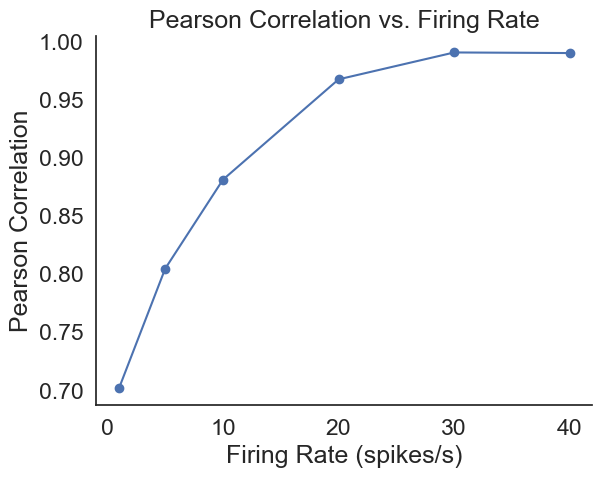

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Generation of the stimulus
duration = 100
dt = 0.1
std_dev = 1
vf_size = (15, 15)
n_bins = round(duration / float(dt))

S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])

# Lambda is the firing rate
def generate_inhomogeneous_poisson_spikes(lamda, dt):
    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # Generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # Throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        # Number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # Generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s) * dt
        spike_times.extend(ts)

    return np.asarray(spike_times)

# Fixing the duration to 100s
duration = 100
n_bins = round(duration / float(dt))

# Preparing the stimulus and fitting the model for different firing rates
firing_rates = [1, 5, 10, 20, 30, 40]
correlations = []

for firing_rate in firing_rates:
    # Flatten the matrices into 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S[:n_bins].reshape(n_bins, -1)
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

    # 1. Linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. Nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    # Lambda * dt is the number of spikes in the different bins
    expected_rate = np.sum(lamda * dt) / duration
    lamda *= (firing_rate / expected_rate)

    # Generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # Compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times, bins=np.arange(n_bins+1) * dt)[0]

    # Define functions for minimization
    def cost(k, spike_counts, S, dt):
        # Negative loglikelihood function to minimize
        ks = np.dot(k, S.T)
        lamda = np.exp(ks)
        return -np.dot(spike_counts, ks) + dt * np.sum(lamda)

    def grad(k, spike_counts, S, dt):
        # Expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)
        ks = np.dot(k, S.T)
        lamda = np.exp(ks)
        return -np.dot(S.T, spike_counts - dt * lamda)

    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun=cost, x0=k_STA / 10, args=(spike_counts, S_flat, dt), method='Newton-CG', jac=grad)

    K_est = res.x

    # Calculate Pearson correlation
    pearson_corr = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
    correlations.append(pearson_corr)

# Plotting
plt.plot(firing_rates, correlations, marker='o')
plt.xlabel('Firing Rate (spikes/s)')
plt.ylabel('Pearson Correlation')
plt.title('Pearson Correlation vs. Firing Rate')
plt.show()
